# Prediction

Both classification and regression models implement tools for prediction. Classifiers provide `predict_proba` (probabilities) and `predict` (labels), while regressors provide `predict` (continuous values). 

The prediction can be either done using a single nearest local model or using the ensemble of local models available within the bandwidth.

## Classification prediction

See that in action with a classifier:

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics
from sklearn.model_selection import train_test_split

from gwlearn.ensemble import GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf['point'] = gdf.representative_point()
gdf = gdf.set_geometry('point').set_index("FIPS")

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

Leave out some locations for prediction later.

In [3]:
X_train, X_test, y_train, y_test, geom_train, geom_test = train_test_split(X, y, gdf.geometry, test_size=.1)

Fit the model using the training subset. If you plan to do the prediction, you need to store the local models, which is False by default. When set to True, all the models are kept in memory, so be careful with large datasets. If given a path, all the models will be stored on disk instead, freeing the memory load.

In [4]:
gwrf = GWLogisticRegression(
    geometry=geom_train,
    bandwidth=250,
    fixed=False,
    keep_models=True,
)
gwrf.fit(
    X_train,
    y_train,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,True
,geometry,FIPS 26135 ...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None


### Using the nearest local model

Now, you can use the test subset to get the prediction. The default behaviour finds the nearest local model and uses it to get the prediction.

In [5]:
proba = gwrf.predict_proba(X_test, geometry=geom_test)
proba

,False,True
FIPS,,
36121,3.446761e-01,0.655324
55127,9.480432e-01,0.051957
42025,5.444216e-01,0.455578
13023,NaN,NaN
48369,8.467173e-01,0.153283
...,...,...
23027,4.230040e-01,0.576996
48303,5.140688e-11,1.000000
12023,NaN,NaN


You can then check the accuracy of this prediction. Note that similarly to fitting, there might be locations that return NA, if the local model was not fitted due to invariance.

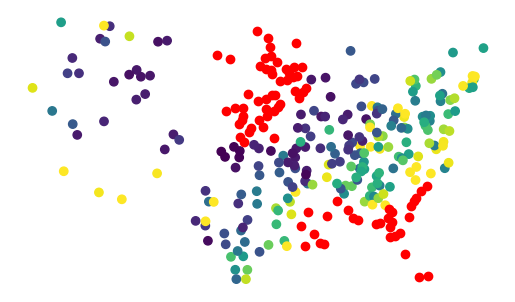

In [6]:
gpd.GeoDataFrame(proba, geometry=geom_test).plot(True, missing_kwds=dict(color='red')).set_axis_off()

The missing values have been linked to models that were not fitted. You can check all of those visually by plotting the focal prediction.

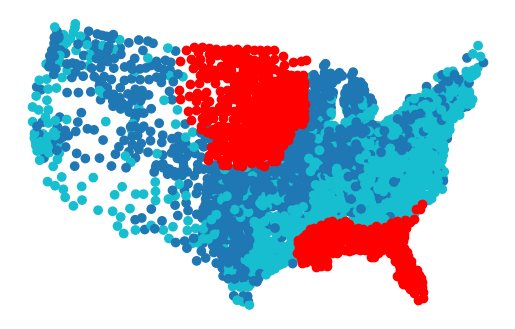

In [ ]:
geom_train.to_frame().plot(gwrf.pred_, missing_kwds=dict(color='red')).set_axis_off()

Filter it out and measure the performance on the left-out sample.

In [7]:
na_mask = proba.isna().any(axis=1)

pred = proba[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.8268398268398268

### Using the ensemble of local models

In case of the ensemble-based prediction, the process works as follows:

1. For a new location on which you want a prediction, identify local models within the set bandwidth. If `bandwidth=None`, uses the bandwidth set at the fit time.
2. Apply the kernel function used to train the model to derive weights of each of the local models.
3. Make prediction using each of the local models in the bandwidth.
4. Make weighted average of predictions based on the kernel weights.
5. For classifiers, normalize the result to ensure sum of probabilities is 1.

Note that given the prediction is pulled from an ensemble of local models, it is not particularly performant. However, it shall be spatially robust.

In [ ]:
proba_ensemble = gwrf.predict_proba(X_test, geometry=geom_test, bandwidth=250)
proba_ensemble

,False,True
FIPS,,
36121,4.219741e-01,0.578026
55127,9.340900e-01,0.065910
42025,5.723710e-01,0.427629
13023,8.661357e-01,0.133864
48369,8.473366e-01,0.152663
...,...,...
23027,4.738930e-01,0.526107
48303,1.080369e-07,1.000000
12023,1.303278e-03,0.998697


Given it relies on an ensemble, not a single nearest model, it returns NaN only when all the local models within the bandwidth were not fitted.

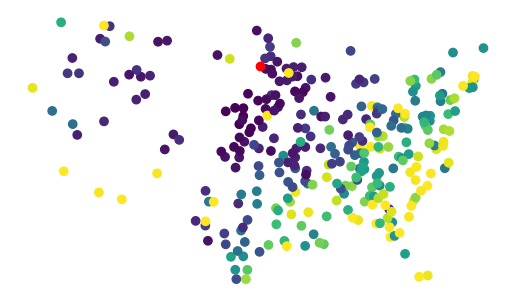

In [10]:
gpd.GeoDataFrame(proba_ensemble, geometry=geom_test).plot(True, missing_kwds=dict(color='red')).set_axis_off()

This is one of the benefits of the ensemble prediction. Another is theoretical spatial robustness. Nevertheless, the actual metrics are typically very similar between the models.

In [11]:
na_mask = proba_ensemble.isna().any(axis=1)
pred = proba_ensemble[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.8474025974025974

## Prediction with regressors

Regression models also implement `predict` method following the same logic as classifiers. Let's see that in action with a `GWLinearRegression`.

In [12]:
from gwlearn.linear_model import GWLinearRegression

Prepare the data with a continuous target variable.

In [13]:
y_reg = gdf["FH90"]  # Use the continuous variable directly

X_train_reg, X_test_reg, y_train_reg, y_test_reg, geom_train_reg, geom_test_reg = train_test_split(
    X, y_reg, gdf.geometry, test_size=0.1, random_state=42
)

Fit the regression model with `keep_models=True` to enable prediction.

In [14]:
gwrf_reg = GWLinearRegression(
    geometry=geom_train_reg,
    bandwidth=250,
    fixed=False,
    keep_models=True,
)
gwrf_reg.fit(
    X_train_reg,
    y_train_reg,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,True
,geometry,FIPS 48005 ...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None


Make predictions on the test set using the `predict` method.

In [15]:
pred_reg = gwrf_reg.predict(X_test_reg, geometry=geom_test_reg)
pred_reg

FIPS
51101    11.457256
13231    15.005252
47019    13.176498
16053     8.860581
21233    12.020863
           ...    
17099    11.625854
38081     6.883169
13317    17.669495
40005    13.573489
39149    10.530572
Length: 309, dtype: float64

Visualize the predicted values spatially.

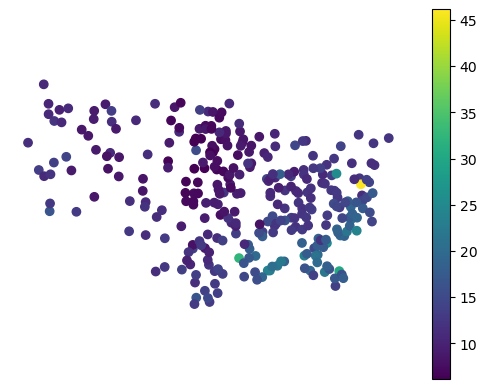

In [16]:
gpd.GeoDataFrame({"prediction": pred_reg}, geometry=geom_test_reg).plot(
    "prediction", legend=True
).set_axis_off()

Evaluate the prediction performance using common regression metrics.

In [17]:
print(f"R2 score: {metrics.r2_score(y_test_reg, pred_reg):.3f}")
print(f"RMSE: {metrics.root_mean_squared_error(y_test_reg, pred_reg):.3f}")

R2 score: 0.652
RMSE: 3.316


The ensemble prediction is available analogously to classifiers.

In [ ]:
pred_reg_ensemble = gwrf_reg.predict(X_test_reg, geometry=geom_test_reg, bandwidth=None)
pred_reg_ensemble

FIPS
51101    11.489416
13231    14.672679
47019    13.041364
16053     9.080974
21233    12.289937
           ...    
17099    11.493070
38081     7.248033
13317    17.023484
40005    13.408702
39149    10.781169
Length: 309, dtype: float64

In [21]:
print(f"R2 score: {metrics.r2_score(y_test_reg, pred_reg_ensemble):.3f}")
print(f"RMSE: {metrics.root_mean_squared_error(y_test_reg, pred_reg_ensemble):.3f}")

R2 score: 0.650
RMSE: 3.327
